In [1]:
import warnings
warnings.filterwarnings("ignore")


import requests

import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 

from wrangle import get_crypto_price


In [2]:
btc = get_crypto_price('btc', '2018-01-01', '2022-12-12')

In [3]:
# human splitting by year
train = btc[:'2020']
validate = btc['2021']
test = btc['2022']

col = 'btc_volume'

In [4]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [5]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [6]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


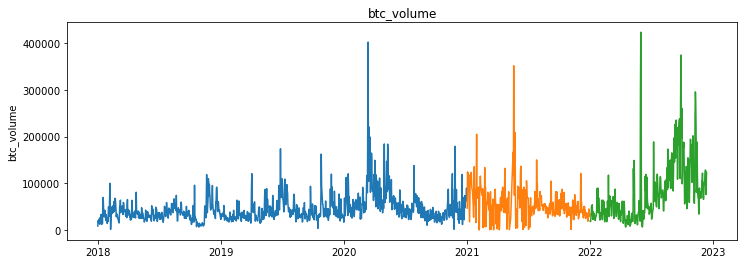

In [7]:
# plot our volume data across train, validate, and test
plt.figure(figsize=(12,4))
plt.plot(train[col])
plt.plot(validate[col])
plt.plot(test[col])
plt.ylabel(col)
plt.title(col)
plt.show()


# Last Observed Value

In [8]:
# get last observed value
volume = train['btc_volume'][-1:][0]

yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)

yhat_df.head()

,btc_volume
date,
2021-01-01,62421.605878
2021-01-02,62421.605878
2021-01-03,62421.605878
2021-01-04,62421.605878
2021-01-05,62421.605878


btc_volume -- RMSE: 36122


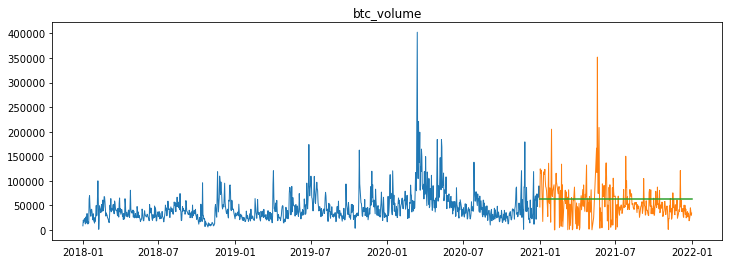

In [9]:
plot_and_eval(col)

In [10]:
# evaluate last observed
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)


In [11]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36122.0


# Simple Average

In [12]:
# getting the average of btc_volume in train
volume = round(train['btc_volume'].mean(), 2)


yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)

yhat_df.head()


,btc_volume
date,
2021-01-01,44901.11
2021-01-02,44901.11
2021-01-03,44901.11
2021-01-04,44901.11
2021-01-05,44901.11


btc_volume -- RMSE: 36649


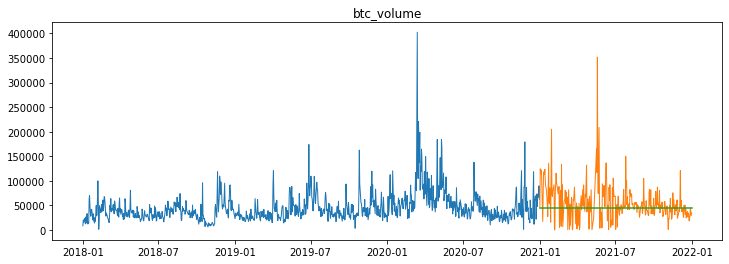

In [13]:
plot_and_eval(col)

In [14]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36122.0
1,simple_average,btc_volume,36649.0


# Moving Average

In [15]:
# trying a 30d period
period = 30
volume = round(train['btc_volume'].rolling(period).mean().iloc[-1], 2)


yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)

yhat_df.head()

,btc_volume
date,
2021-01-01,50172.69
2021-01-02,50172.69
2021-01-03,50172.69
2021-01-04,50172.69
2021-01-05,50172.69


btc_volume -- RMSE: 35595


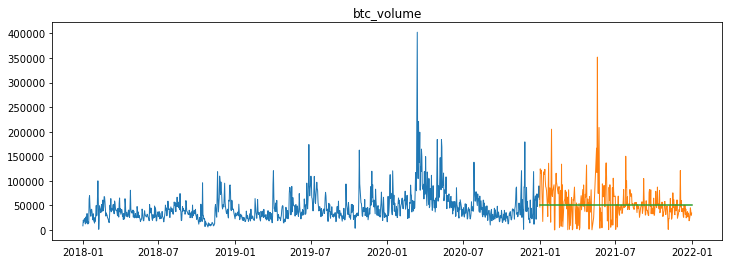

In [16]:
plot_and_eval(col)

In [17]:
eval_df = append_eval_df(model_type='30d_moving_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36122.0
1,simple_average,btc_volume,36649.0
2,30d_moving_average,btc_volume,35595.0


# Several periods

In [18]:
# try out several periods
periods = [1,7,14,21,28,120]

for p in periods:
    volume = round(train['btc_volume'].rolling(p).mean().iloc[-1], 2)


    yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)
    
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type, 
                             target_var = col)

In [19]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36122.0
1,simple_average,btc_volume,36649.0
2,30d_moving_average,btc_volume,35595.0
3,1d moving average,btc_volume,36122.0
4,7d moving average,btc_volume,38153.0
5,14d moving average,btc_volume,35642.0
6,21d moving average,btc_volume,35355.0
7,28d moving average,btc_volume,35597.0
8,120d moving average,btc_volume,37821.0


In [20]:
# get min rmse of eval_df so far
min_rmse_volume = eval_df.groupby('target_var')['rmse'].min()[0]

eval_df[(eval_df.rmse == min_rmse_volume)]

,model_type,target_var,rmse
6,21d moving average,btc_volume,35355.0


# Holt's Linear Trend

btc_volume 



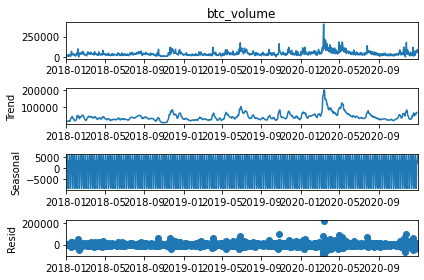

In [38]:
# doing some seaonal decomposition for volume

print(col,'\n')
_ = sm.tsa.seasonal_decompose(train[col].resample('D').mean()).plot()
#plt.figure(figsize=(12,8))
plt.show()

In [39]:
# adjusted smoothing level and smoothing slope to fit data better
# but i may have just forced my model to overfit, maybe
# need to run this by instructors

model = Holt(train[col], exponential = False)
model = model.fit(smoothing_level = .03, 
                smoothing_slope = .01, 
                optimized = False)

yhat_items = model.predict(start = validate.index[0], 
                        end = validate.index[-1])

yhat_df[col] = round(yhat_items, 2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


btc_volume -- RMSE: 37793


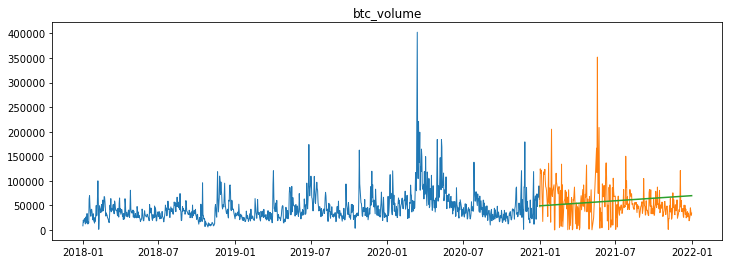

In [40]:
# plotting holt model
plot_and_eval(target_var = col)

In [41]:
eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36122.0
1,simple_average,btc_volume,36649.0
2,30d_moving_average,btc_volume,35595.0
3,1d moving average,btc_volume,36122.0
4,7d moving average,btc_volume,38153.0
5,14d moving average,btc_volume,35642.0
6,21d moving average,btc_volume,35355.0
7,28d moving average,btc_volume,35597.0
8,120d moving average,btc_volume,37821.0
9,Holts,btc_volume,37793.0


# Previous Cycle (not cyclic enough, data also missing 40 days in 2021)

In [54]:
resampled_2021 = validate.resample('D').mean()

In [55]:
resampled_2021.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Freq: D
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   btc_open    326 non-null    float64
 1   btc_high    326 non-null    float64
 2   btc_low     326 non-null    float64
 3   btc_close   326 non-null    float64
 4   btc_volume  326 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [56]:
resampled_2021

,btc_open,btc_high,btc_low,btc_close,btc_volume
date,,,,,
2021-01-01,28923.63,29600.00,28624.57,29263.09,46884.263225
2021-01-02,29331.70,33300.00,28946.53,32100.04,124427.120161
2021-01-03,32176.45,34778.11,31962.99,33000.05,115941.583083
2021-01-04,33000.05,33600.00,28130.00,31988.71,121959.073778
2021-01-05,31989.75,34360.00,29900.00,33949.53,114934.175737
...,...,...,...,...,...
2021-12-27,50775.48,52088.00,50449.00,50701.44,28491.333770
2021-12-28,50701.44,50704.05,47313.01,47543.74,45174.083720
2021-12-29,47543.69,48139.08,46096.99,46464.66,38942.397470


In [42]:
#volume = round(train['btc_volume'].rolling(365).mean().iloc[-1], 2)


#yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
#                       index = validate.index)
    
#model_type = str(p) + '365d moving average'
#eval_df = append_eval_df(model_type = '365d moving average', 
#                             target_var = col)

In [25]:

#m_train = btc[:'2020']
#m_validate = btc['2020']
#m_test = btc['2021']


In [26]:
#yhat_df = train['2020'] + train.diff(365).mean() 

In [27]:
#len(train['2020'])

In [28]:
#len(btc['2021'])

In [29]:
#pd.concat([yhat_df.head(1), m_test.head(1)])

In [30]:
#yhat_df.index = m_test.index

#len(yhat_df)

In [31]:
#plot_and_eval(target_var = col)
#eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [32]:
#btc['2021'].index.value_counts()

In [33]:
#print(btc['2021'].to_string())

In [34]:
#print(btc['2020'].to_string())

In [35]:
#yhat_df

# Move on to test

In [43]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,btc_volume,36122.0
1,simple_average,btc_volume,36649.0
2,30d_moving_average,btc_volume,35595.0
3,1d moving average,btc_volume,36122.0
4,7d moving average,btc_volume,38153.0
5,14d moving average,btc_volume,35642.0
6,21d moving average,btc_volume,35355.0
7,28d moving average,btc_volume,35597.0
8,120d moving average,btc_volume,37821.0
9,Holts,btc_volume,37793.0


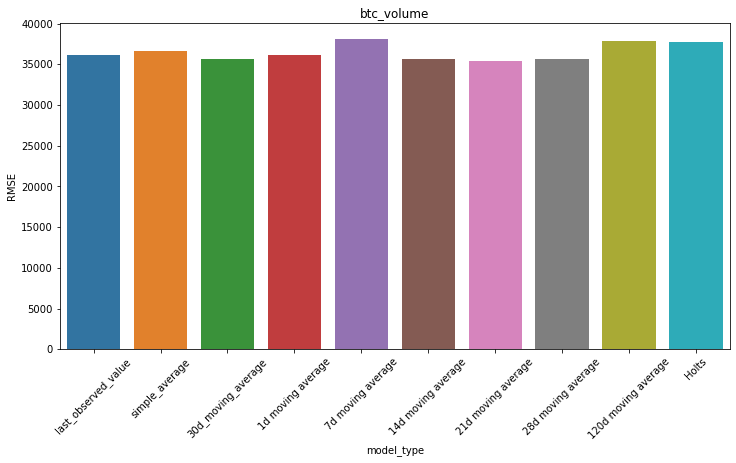

In [37]:
x = eval_df[eval_df.target_var == col]['model_type']
y = eval_df[eval_df.target_var == col]['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()